# RET-CLIP Prompt Generation

This notebook generates varied clinical prompts for training RET-CLIP on retinal fundus images.

**Dataset:** Peacein/color-fundus-eye (12,989 samples, 10 disease classes)

**Output:** CSV file with `dataset_index`, `label`, and `prompt` columns

---

## Quick Start Instructions

1. **Run Cell 1** below to install all required packages (one-time setup, ~2-5 minutes)
2. **Set your API keys** in Cell 3 (HuggingFace and OpenRouter tokens)
3. **Adjust parameters** in Cell 4 (number of samples, etc.)
4. **Run all cells** to generate prompts

**⏱️ Estimated time:**
- 100 samples: ~30 minutes
- Full dataset (12,989): ~9-10 hours

**💡 Tip:** The notebook auto-saves checkpoints - you can stop and resume anytime!

## 1. 📦 Install Required Packages

**👉 Run this cell first!** It will automatically install all necessary packages using pip.

This may take 2-5 minutes the first time. You only need to run this once.

If you encounter any errors, try restarting the kernel (Kernel → Restart) and running this cell again.

In [2]:
# Install all required packages using pip
import sys
import subprocess

packages = [
    'dspy-ai',           # DSPy framework for LLM prompting
    'datasets',          # HuggingFace datasets library
    'huggingface-hub',   # HuggingFace authentication
    'pandas',            # Data manipulation
    'pillow',            # Image processing
    'tqdm',              # Progress bars
    'ipywidgets',        # Interactive widgets (optional)
    'matplotlib',        # Plotting
]

print("📦 Installing required packages...")
print("This may take 2-5 minutes the first time.\n")

for i, package in enumerate(packages, 1):
    print(f"[{i}/{len(packages)}] Installing {package}...")
    try:
        subprocess.check_call(
            [sys.executable, '-m', 'pip', 'install', '-q', package],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.PIPE
        )
        print(f"    ✅ {package} installed")
    except subprocess.CalledProcessError as e:
        print(f"    ⚠️  {package} - may already be installed or had a non-critical issue")

print("\n" + "="*60)
print("✅ Package installation complete!")
print("="*60)

# Verify installations
print("\nVerifying installations...")
try:
    import dspy
    import datasets
    import pandas as pd
    from tqdm.notebook import tqdm
    import matplotlib
    print("✅ All packages verified successfully!\n")
    print("👉 You can now proceed to the next cell.")
except ImportError as e:
    print(f"❌ Error: {e}")
    print("\nPlease try:")
    print("1. Restart kernel: Kernel → Restart")
    print("2. Re-run this cell")

📦 Installing required packages...
This may take 2-5 minutes the first time.

[1/8] Installing dspy-ai...
    ✅ dspy-ai installed
[2/8] Installing datasets...
    ✅ datasets installed
[3/8] Installing huggingface-hub...
    ✅ huggingface-hub installed
[4/8] Installing pandas...
    ✅ pandas installed
[5/8] Installing pillow...
    ✅ pillow installed
[6/8] Installing tqdm...
    ✅ tqdm installed
[7/8] Installing ipywidgets...
    ✅ ipywidgets installed
[8/8] Installing matplotlib...
    ✅ matplotlib installed

✅ Package installation complete!

Verifying installations...
✅ All packages verified successfully!

👉 You can now proceed to the next cell.


## 2. Imports

In [3]:
import os
import random
import time
from typing import Optional

import pandas as pd
from tqdm.notebook import tqdm  # Notebook-friendly progress bars
from datasets import load_dataset
from huggingface_hub import login
import dspy

# For visualizations
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output

# Optional: Interactive widgets
try:
    import ipywidgets as widgets
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("Note: ipywidgets not available. Install with: uv pip install ipywidgets")

## 3. Configuration Parameters

**⚙️ Adjust these settings before running:**

- `LIMIT`: Number of samples (100 for testing, 12989 for full dataset)
- `CHECKPOINT_INTERVAL`: How often to save progress
- Set your API keys below if not in environment variables

In [4]:
# Dataset Configuration
DATASET_NAME = "Peacein/color-fundus-eye"
SPLIT = "train"

# Output Configuration
OUTPUT_PATH = "./content/retclip_prompts_full.csv"

# Generation Parameters
LIMIT = 100  # Number of samples to process (set to 12989 for full dataset, or None)
SEED = 42
CHECKPOINT_INTERVAL = 10  # Save checkpoint every N samples
DELAY_BETWEEN_CALLS = 1.0  # Seconds between API calls (INCREASED FROM 0.5)
USE_CHAIN_OF_THOUGHT = False  # Slower but potentially better reasoning

# 🔄 VERIFIED FREE VISION MODELS from OpenRouter
# These models ACTUALLY exist and support vision (checked via API)
PRIMARY_MODEL = "openrouter/google/gemini-2.5-flash-lite-preview-09-2025"
FALLBACK_MODELS = [
    # No other free vision models available currently on OpenRouter
    # If primary fails, the notebook will retry with backoff
    "openrouter/mistralai/mistral-small-3.2-24b-instruct:free",
    "openrouter/openai/gpt-5-nano",
    "openrouter/mistralai/mistral-small-3.1-24b-instruct:free",
    "openrouter/google/gemini-2.0-flash-exp:free"
]

# API Keys (will try environment variables first)
HF_TOKEN = os.getenv("HF_TOKEN") or os.getenv("HUGGINGFACE_HUB_TOKEN")
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

print(f"Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Output: {OUTPUT_PATH}")
print(f"  Samples: {LIMIT if LIMIT else 'All (12,989)'}")
print(f"  Checkpoint interval: {CHECKPOINT_INTERVAL}")
print(f"  Delay between calls: {DELAY_BETWEEN_CALLS}s (INCREASED for stability)")
print(f"  Primary model: {PRIMARY_MODEL.split('/')[-1].replace(':free', '')} (VERIFIED FREE VISION)")
print(f"  Fallback models: {len(FALLBACK_MODELS)} (currently no other free vision models)")
print(f"  HF Token: {'✅ Set' if HF_TOKEN else '❌ Not set'}")
print(f"  OpenRouter Key: {'✅ Set' if OPENROUTER_API_KEY else '❌ Not set'}")

Configuration:
  Dataset: Peacein/color-fundus-eye
  Output: ./content/retclip_prompts_full.csv
  Samples: 100
  Checkpoint interval: 10
  Delay between calls: 1.0s (INCREASED for stability)
  Primary model: gemini-2.5-flash-lite-preview-09-2025 (VERIFIED FREE VISION)
  Fallback models: 4 (currently no other free vision models)
  HF Token: ❌ Not set
  OpenRouter Key: ❌ Not set


### 🔑 Set API Keys

**Important:** You need two API keys to run this notebook:

1. **HuggingFace Token** - For downloading the dataset
   - Get it here: https://huggingface.co/settings/tokens
   - Click "New token" → Name it "retclip" → Copy the token

2. **OpenRouter API Key** - For the AI model
   - Get it here: https://openrouter.ai/keys
   - Click "Create Key" → Copy the key

**How to set keys:**
- Option 1: Uncomment and paste your keys in the cell below (easiest)
- Option 2: Set environment variables before starting Jupyter (more secure)

In [ ]:
# Uncomment and set your API keys if not in environment variables
HF_TOKEN = "hf_YOUR_TOKEN_HERE"  # Replace with your token from https://huggingface.co/settings/tokens
OPENROUTER_API_KEY = "sk-or-v1-YOUR_KEY_HERE"  # Replace with your key from https://openrouter.ai/keys

if not HF_TOKEN or HF_TOKEN == "hf_YOUR_TOKEN_HERE":
    print("⚠️ HF_TOKEN not set. Dataset download may fail.")
if not OPENROUTER_API_KEY or OPENROUTER_API_KEY == "sk-or-v1-YOUR_KEY_HERE":
    print("⚠️ OPENROUTER_API_KEY not set. LLM calls will fail.")

## 4. Authentication & LLM Setup

In [6]:
# Authenticate with HuggingFace
if HF_TOKEN:
    login(token=HF_TOKEN)
    print("✅ Authenticated with HuggingFace")
else:
    print("⚠️ No HF_TOKEN - dataset download may fail for private datasets")

# Configure LLM with built-in fallback support (FIXED: use model names, not LM objects)
if OPENROUTER_API_KEY:
    try:
        # IMPORTANT: DSPy's fallback parameter expects model name STRINGS, not LM objects
        # This was causing "Object of type LM is not JSON serializable" error

        primary_lm = dspy.LM(
            model=PRIMARY_MODEL,
            api_key=OPENROUTER_API_KEY,
            api_base="https://openrouter.ai/api/v1",
            extra_headers={"HTTP-Referer": "https://chiron.app", "X-Title": "Chiron"},
            fallback=FALLBACK_MODELS,  # Pass model names directly as list of strings
            num_retries=3,
        )

        dspy.configure(lm=primary_lm)
        print(f"✅ LLM configured with automatic fallback:")
        print(f"   Primary: {PRIMARY_MODEL.split('/')[-1].replace(':free', '')}")
        for i, model in enumerate(FALLBACK_MODELS, 1):
            model_name = model.split('/')[-1].replace(':free', '')
            print(f"   Fallback {i}: {model_name}")
    except Exception as e:
        print(f"❌ Error configuring LLM: {e}")
        print("   Check your API key and model availability")
        raise
else:
    print("❌ OPENROUTER_API_KEY not set - cannot configure LLM")

✅ Authenticated with HuggingFace
✅ LLM configured with automatic fallback:
   Primary: gemini-2.5-flash-lite-preview-09-2025
   Fallback 1: mistral-small-3.2-24b-instruct
   Fallback 2: gpt-5-nano
   Fallback 3: mistral-small-3.1-24b-instruct
   Fallback 4: gemini-2.0-flash-exp


## 5. Load Dataset & Inspect

In [7]:
# Load dataset in streaming mode
print(f"Loading dataset: {DATASET_NAME}")
dset = load_dataset(DATASET_NAME, split=SPLIT, streaming=True)

# Get label mappings
label_names = dset.features['label'].names
print(f"\n✅ Found {len(label_names)} disease classes:")
for idx, name in enumerate(label_names):
    print(f"  {idx} → {name}")

Loading dataset: Peacein/color-fundus-eye


Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/12989 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3253 [00:00<?, ?it/s]


✅ Found 10 disease classes:
  0 → Central Serous Chorioretinopathy [Color Fundus]
  1 → Diabetic Retinopathy
  2 → Disc Edema
  3 → Glaucoma
  4 → Healthy
  5 → Macular Scar
  6 → Myopia
  7 → Pterygium
  8 → Retinal Detachment
  9 → Retinitis Pigmentosa


Sample structure:
  Keys: dict_keys(['image', 'label'])
  Label: 0 → Central Serous Chorioretinopathy [Color Fundus]
  Image: <class 'PIL.JpegImagePlugin.JpegImageFile'>


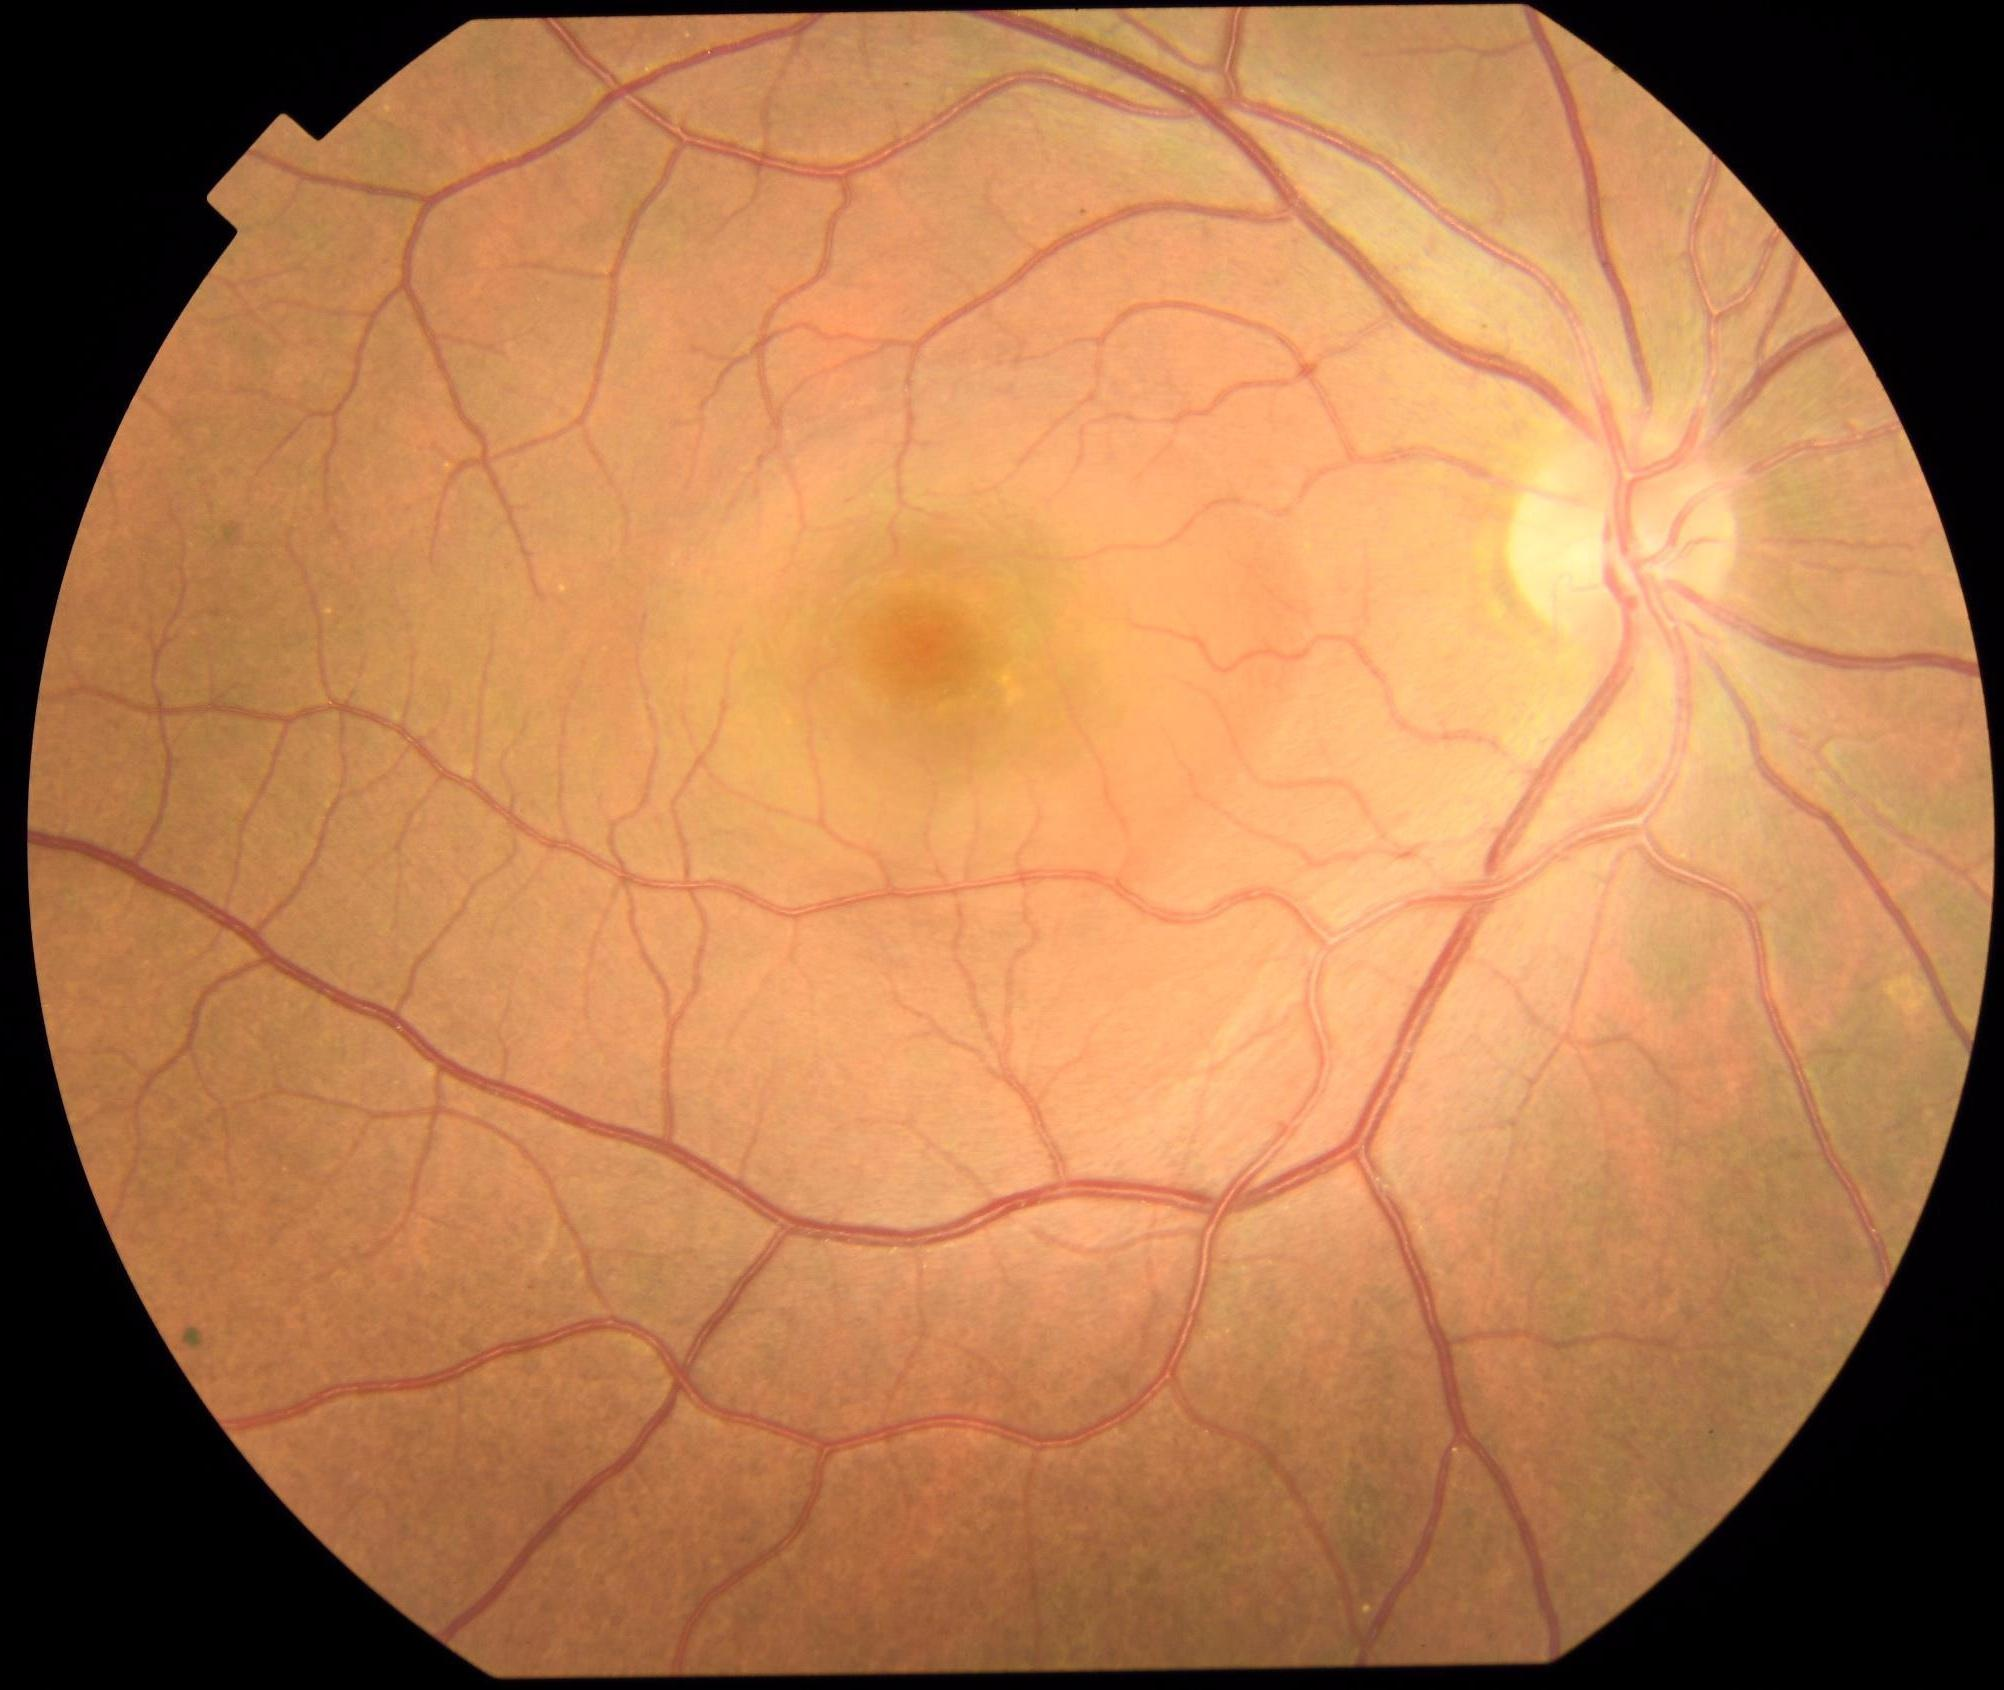

In [8]:
# Preview first sample
sample = next(iter(dset))
print(f"Sample structure:")
print(f"  Keys: {sample.keys()}")
print(f"  Label: {sample['label']} → {label_names[sample['label']]}")
print(f"  Image: {type(sample['image'])}")

# Display image
display(sample['image'])

## 6. DSPy Classes & Functions

In [9]:
class ClinicalPromptSignature(dspy.Signature):
    """Generate a clinical diagnostic impression for a retinal fundus image.

    Requirements:
    - Use varied medical terminology
    - Be concise (1-2 sentences)
    - Include relevant clinical features when visible
    - Vary phrasing to avoid repetition
    """

    image = dspy.InputField(desc="Color fundus photograph")
    disease = dspy.InputField(desc="Diagnosed retinal condition")
    style_hint = dspy.InputField(desc="Writing style guidance")

    impression = dspy.OutputField(desc="Clinical diagnostic impression")

In [10]:
class RetinalPromptGenerator(dspy.Module):
    """Generates varied clinical prompts for fundus images."""

    def __init__(self, use_chain_of_thought: bool = False):
        super().__init__()

        # Choose between simple prediction or chain-of-thought
        if use_chain_of_thought:
            self.generate = dspy.ChainOfThought(ClinicalPromptSignature)
        else:
            self.generate = dspy.Predict(ClinicalPromptSignature)

        # Style variations for randomization
        self.writing_styles = [
            "formal and detailed",
            "concise and direct",
            "descriptive with key findings",
            "focused on diagnostic features",
            "educational clinical note style",
            "brief assessment format",
        ]

        self.perspectives = [
            "describe visible pathology",
            "summarize diagnostic impression",
            "note clinical significance",
            "describe characteristic findings",
            "identify key abnormalities",
        ]

        self.detail_levels = ["brief", "moderate", "detailed"]

    def _create_style_hint(self, rng: random.Random) -> str:
        """Create a randomized style hint."""
        style = rng.choice(self.writing_styles)
        perspective = rng.choice(self.perspectives)
        detail = rng.choice(self.detail_levels)

        return f"{detail} description, {style}, {perspective}"

    def forward(self, image, disease: str, rng: Optional[random.Random] = None):
        """Generate a clinical prompt for the given image and disease."""
        rng = rng or random.Random()

        style_hint = self._create_style_hint(rng)

        result = self.generate(
            image=image,
            disease=disease,
            style_hint=style_hint
        )

        # Clean up the output
        impression = result.impression.strip()

        # Ensure it ends with a period
        if not impression.endswith(('.', '!', '?')):
            impression += '.'

        # Take only first sentence if multiple were generated
        if '\n' in impression:
            impression = impression.split('\n')[0].strip()

        # Remove model artifacts like [[ ## completed ## ]]
        import re
        impression = re.sub(r'\s*\[\[\s*##\s*completed\s*##\s*\]\]\.?', '', impression)
        impression = impression.strip()

        # Ensure it still ends with a period after cleanup
        if impression and not impression.endswith(('.', '!', '?')):
            impression += '.'

        return impression

## 7. Test Generator on Single Sample

Verify the generator works before running on full dataset:

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/12989 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3253 [00:00<?, ?it/s]

Test Sample:
  Disease: Central Serous Chorioretinopathy [Color Fundus]


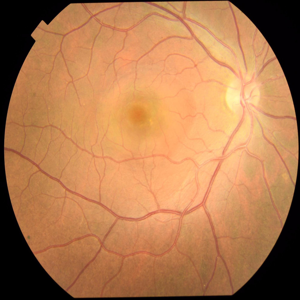


Generating prompt...

✅ Generated Prompt:
  Focal, mildly elevated area of macula noted, consistent with serous neurosensory detachment involving the central macula suggestive of active Central Serous Chorioretinopathy.


In [11]:
# Initialize generator
generator = RetinalPromptGenerator(use_chain_of_thought=USE_CHAIN_OF_THOUGHT)

# Load a test sample
test_dataset = load_dataset(DATASET_NAME, split=SPLIT, streaming=True)
test_sample = next(iter(test_dataset))
test_label = label_names[test_sample['label']]

print(f"Test Sample:")
print(f"  Disease: {test_label}")
display(test_sample['image'].resize((300, 300)))  # Smaller display

# Generate test prompt
print("\nGenerating prompt...")
test_prompt = generator(
    image=test_sample['image'],
    disease=test_label,
    rng=random.Random(42)
)

print(f"\n✅ Generated Prompt:")
print(f"  {test_prompt}")

## 8. Retry Logic (for Rate Limiting)

In [12]:
def retry_with_backoff(func, max_retries: int = 5, base_delay: float = 10.0):
    """Enhanced retry function with exponential backoff and better error handling.

    Handles:
    - Rate limiting (429, quota exceeded)
    - Bad requests (400, JSON schema errors)
    - Model unavailability (404, not found)

    Note: DSPy handles fallback models automatically, but this provides
    additional retry logic if all models are temporarily exhausted.
    """
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            error_str = str(e).lower()

            # Categorize errors
            is_rate_limit = any(kw in error_str for kw in ["rate limit", "429", "quota", "too many requests"])
            is_bad_request = any(kw in error_str for kw in ["400", "bad request", "json schema"])
            is_not_found = any(kw in error_str for kw in ["404", "not found", "no endpoints"])

            # Don't retry 404 errors - model doesn't exist
            if is_not_found:
                print(f"❌ Model unavailable (404): {error_str[:150]}")
                raise

            # Don't retry JSON schema errors - let DSPy handle fallback
            if is_bad_request and "json schema" in error_str:
                print(f"❌ JSON schema error (will try fallback model)")
                raise

            # Last attempt - give up
            if attempt == max_retries - 1:
                print(f"❌ Max retries ({max_retries}) exhausted")
                raise

            # Calculate backoff delay
            if is_rate_limit:
                delay = base_delay * (2 ** attempt) + random.uniform(0, 5)
                print(f"⏳ Rate limited. Waiting {delay:.1f}s (retry {attempt + 1}/{max_retries})")
            else:
                delay = base_delay + random.uniform(0, 3)
                print(f"⚠️ Error occurred. Waiting {delay:.1f}s (retry {attempt + 1}/{max_retries})")
                print(f"   Error: {error_str[:150]}")

            time.sleep(delay)

## 9. Check for Existing Checkpoint

In [13]:
checkpoint_path = OUTPUT_PATH

if os.path.exists(checkpoint_path):
    checkpoint_df = pd.read_csv(checkpoint_path)
    print(f"✅ Checkpoint found: {len(checkpoint_df)} samples already processed")
    print(f"   Will resume from index {len(checkpoint_df)}")

    # Show latest samples
    print("\nLatest samples in checkpoint:")
    display(checkpoint_df.tail(5))

    # Option to continue or start fresh
    if HAS_WIDGETS:
        resume_button = widgets.Button(description="Resume")
        fresh_button = widgets.Button(description="Start Fresh")

        def on_resume(b):
            print("Resuming from checkpoint...")

        def on_fresh(b):
            if os.path.exists(checkpoint_path):
                os.remove(checkpoint_path)
            print("Starting fresh (checkpoint removed)")

        resume_button.on_click(on_resume)
        fresh_button.on_click(on_fresh)

        display(widgets.HBox([resume_button, fresh_button]))
else:
    print("No checkpoint found - will start from beginning")

✅ Checkpoint found: 12989 samples already processed
   Will resume from index 12989

Latest samples in checkpoint:


dataset_index                 label  \
12984          12984  Retinitis Pigmentosa   
12985          12985  Retinitis Pigmentosa   
12986          12986  Retinitis Pigmentosa   
12987          12987  Retinitis Pigmentosa   
12988          12988  Retinitis Pigmentosa   

                                                  prompt  
12984  The fundus examination reveals classic feature...  
12985  The fundus exhibits clear signs consistent wit...  
12986  The fundus examination demonstrates classic fe...  
12987  The fundus photograph reveals classic signs co...  
12988  Widespread attenuation of the retinal vasculat...

## 10. Main Generation Loop

**⚠️ This will take several hours for the full dataset!**

- Progress bar shows real-time updates
- Checkpoints saved every N samples (resumable)
- Rate limiting handled automatically

In [14]:
LIMIT = 12989

In [15]:
# Initialize
start_index = 0
rows = []

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint_df = pd.read_csv(checkpoint_path)
    rows = checkpoint_df.to_dict('records')
    start_index = len(rows)
    print(f"Resuming from index {start_index}")

# Reload dataset
dset = load_dataset(DATASET_NAME, split=SPLIT, streaming=True)
label_names = dset.features['label'].names

# Initialize generator
generator = RetinalPromptGenerator(use_chain_of_thought=USE_CHAIN_OF_THOUGHT)

# Determine total
total = LIMIT if LIMIT else 12989

# Skip to start position
dset_iter = iter(dset)
for _ in range(start_index):
    try:
        next(dset_iter)
    except StopIteration:
        break

print(f"\nGenerating prompts...")
print(f"Checkpoint interval: {CHECKPOINT_INTERVAL}")
print(f"Delay between calls: {DELAY_BETWEEN_CALLS}s\n")

# Progress bar
pbar = tqdm(range(start_index, start_index + total), initial=start_index, total=start_index + total)
try:
    for i in pbar:
        try:
            ex = next(dset_iter)

            # Get disease label
            label_idx = ex.get('label')
            disease = label_names[label_idx] if label_idx < len(label_names) else str(label_idx)

            # Create deterministic RNG based on index
            rng = random.Random(i ^ SEED)

            # Generate prompt with retry logic
            def make_prompt():
                return generator(image=ex['image'], disease=disease, rng=rng)

            prompt = retry_with_backoff(make_prompt)

            # Store result
            rows.append({
                'dataset_index': i,
                'label': disease,
                'prompt': prompt,
            })
            print(f"Generation: {prompt}, class: {disease}")

            # Update progress bar description
            pbar.set_description(f"Processing {disease[:30]}...")

            # Save checkpoint
            if (i + 1) % CHECKPOINT_INTERVAL == 0:
                pd.DataFrame(rows).to_csv(checkpoint_path, index=False)
                pbar.write(f"Checkpoint saved at index {i + 1}")

            # Rate limiting delay
            if i < start_index + total - 1:
                time.sleep(DELAY_BETWEEN_CALLS)

        except StopIteration:
            print(f"\nReached end of dataset at index {i}")
            break

        except Exception as e:
            print(f"\nError at index {i}: {e}")
            # Save checkpoint on error
            pd.DataFrame(rows).to_csv(checkpoint_path, index=False)
            print("Checkpoint saved after error.")
            continue

except KeyboardInterrupt:
    print(f"\n\nInterrupted at index {i}. Saving checkpoint...")
    pd.DataFrame(rows).to_csv(checkpoint_path, index=False)
    print(f"Checkpoint saved with {len(rows)} rows.")

# Save final dataset
df = pd.DataFrame(rows)
df.to_csv(OUTPUT_PATH, index=False)

# Clean up checkpoint
if os.path.exists(checkpoint_path):
    print("\nCheckpoint file removed after successful completion")

print(f"\n✅ Complete! Generated {len(df)} prompts")
print(f"Saved to: {OUTPUT_PATH}")

Resuming from index 12989


Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/12989 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3253 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 11. Analyze Results

In [16]:
# Load results
df = pd.read_csv(OUTPUT_PATH)

print(f"Total prompts generated: {len(df)}")
print(f"Unique prompts: {df['prompt'].nunique()} ({df['prompt'].nunique()/len(df)*100:.1f}%)")

# Show sample results
print("\n" + "=" * 80)
print("Sample Results:")
print("=" * 80)

for i, row in df.head(5).iterrows():
    print(f"\n[{i+1}] {row['label']}")
    print(f"    {row['prompt']}")

Total prompts generated: 12989
Unique prompts: 12785 (98.4%)

Sample Results:

[1] Central Serous Chorioretinopathy [Color Fundus]
    A focal subretinal fluid collection with geographic borders is evident, superimposed on a hyperpermeable choroidal stroma. The lesion exhibits minimal overlying retinal involvement but shows perifoveal sparing, suggesting chronic partial resolution. This pattern aligns with recurrent inflammatory serous detachment and atrophy, featuring exudative patterns consistent with choroidal effusion-driven photoreceptor compromise.

[2] Central Serous Chorioretinopathy [Color Fundus]
    Findings confirm Central Serous Chorioretinopathy (CSC), characterized by focal intraretinal effusions elevating the neurosensory retina above the retinal pigment epithelium (RPE)-Bruch's complex, commonly localized to the macular region. Chorioretinal thickening, serous fluid collection, and potential overlying pigment clumping are observed, with notable implications for central

In [17]:
# Label distribution
print("\nLabel Distribution:")
print("=" * 80)
label_counts = df['label'].value_counts()
display(label_counts)


Label Distribution:


label
Diabetic Retinopathy                               2755
Glaucoma                                           2304
Healthy                                            2046
Myopia                                             1926
Macular Scar                                       1517
Retinitis Pigmentosa                                667
Disc Edema                                          609
Retinal Detachment                                  600
Central Serous Chorioretinopathy [Color Fundus]     484
Pterygium                                            81
Name: count, dtype: int64

## 12. Visualizations

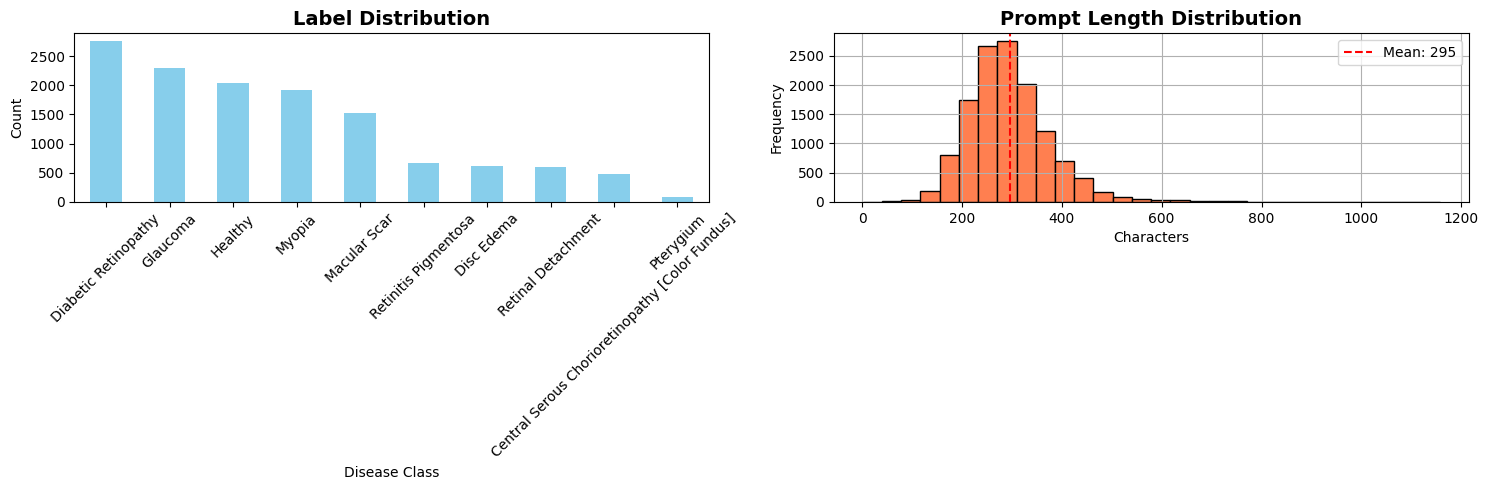


Prompt Length Statistics:
  Min: 1.0 characters
  Max: 1157.0 characters
  Mean: 295.4 characters
  Median: 285.0 characters


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Label distribution
df['label'].value_counts().plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Disease Class')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Prompt length distribution
prompt_lengths = df['prompt'].str.len()
prompt_lengths.hist(bins=30, ax=ax2, color='coral', edgecolor='black')
ax2.set_title('Prompt Length Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Characters')
ax2.set_ylabel('Frequency')
ax2.axvline(prompt_lengths.mean(), color='red', linestyle='--', label=f'Mean: {prompt_lengths.mean():.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nPrompt Length Statistics:")
print(f"  Min: {prompt_lengths.min()} characters")
print(f"  Max: {prompt_lengths.max()} characters")
print(f"  Mean: {prompt_lengths.mean():.1f} characters")
print(f"  Median: {prompt_lengths.median():.1f} characters")

## 13. Diversity Analysis

In [19]:
# Check prompt diversity per label
print("Prompt Diversity by Label:")
print("=" * 80)

diversity_stats = []
for label in df['label'].unique():
    label_df = df[df['label'] == label]
    total = len(label_df)
    unique = label_df['prompt'].nunique()
    diversity = (unique / total * 100) if total > 0 else 0

    diversity_stats.append({
        'Label': label,
        'Total': total,
        'Unique': unique,
        'Diversity %': diversity
    })

diversity_df = pd.DataFrame(diversity_stats).sort_values('Diversity %', ascending=False)
display(diversity_df)

Prompt Diversity by Label:


Label  Total  Unique  Diversity %
9                             Retinitis Pigmentosa    667     667   100.000000
2                                       Disc Edema    609     609   100.000000
8                               Retinal Detachment    600     600   100.000000
7                                        Pterygium     81      81   100.000000
3                                         Glaucoma   2304    2301    99.869792
0  Central Serous Chorioretinopathy [Color Fundus]    484     483    99.793388
1                             Diabetic Retinopathy   2755    2748    99.745917
6                                           Myopia   1926    1893    98.286604
5                                     Macular Scar   1517    1453    95.781147
4                                          Healthy   2046    1950    95.307918

## 14. Export for RET-CLIP Training

Show how to use the generated prompts with the original dataset:

In [20]:
print("Usage Example for RET-CLIP Training:")
print("=" * 80)
print("""
# Load the original dataset
dataset = load_dataset("Peacein/color-fundus-eye", split="train")

# Load generated prompts
prompts_df = pd.read_csv("retclip_prompts_full.csv")

# Training loop
for _, row in prompts_df.iterrows():
    # Get image from original dataset using index
    image = dataset[row['dataset_index']]['image']

    # Get generated prompt
    prompt = row['prompt']
    label = row['label']

    # Train RET-CLIP with (image, prompt) pair
    # model.train(image, prompt, label)
""")

# Test the mapping
print("\nTesting dataset index mapping:")
test_idx = df.iloc[0]['dataset_index']
test_prompt = df.iloc[0]['prompt']
print(f"  Dataset index: {test_idx}")
print(f"  Generated prompt: {test_prompt[:100]}...")

Usage Example for RET-CLIP Training:

# Load the original dataset
dataset = load_dataset("Peacein/color-fundus-eye", split="train")

# Load generated prompts
prompts_df = pd.read_csv("retclip_prompts_full.csv")

# Training loop
for _, row in prompts_df.iterrows():
    # Get image from original dataset using index
    image = dataset[row['dataset_index']]['image']

    # Get generated prompt
    prompt = row['prompt']
    label = row['label']

    # Train RET-CLIP with (image, prompt) pair
    # model.train(image, prompt, label)


Testing dataset index mapping:
  Dataset index: 0
  Generated prompt: A focal subretinal fluid collection with geographic borders is evident, superimposed on a hyperperme...


## 15. Summary Statistics

In [21]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Unique prompts: {df['prompt'].nunique()}")
print(f"  Diversity: {df['prompt'].nunique()/len(df)*100:.1f}%")
print(f"  Disease classes: {df['label'].nunique()}")

print(f"\n📝 Prompt Statistics:")
print(f"  Avg length: {df['prompt'].str.len().mean():.1f} characters")
print(f"  Min length: {df['prompt'].str.len().min()} characters")
print(f"  Max length: {df['prompt'].str.len().max()} characters")

print(f"\n💾 Output Files:")
print(f"  Main file: {OUTPUT_PATH}")
print(f"  File size: {os.path.getsize(OUTPUT_PATH) / 1024:.1f} KB")

print("\n✅ Generation complete!")


FINAL SUMMARY

📊 Dataset Statistics:
  Total samples: 12989
  Unique prompts: 12785
  Diversity: 98.4%
  Disease classes: 10

📝 Prompt Statistics:
  Avg length: 295.4 characters
  Min length: 1.0 characters
  Max length: 1157.0 characters

💾 Output Files:
  Main file: ./content/retclip_prompts_full.csv
  File size: 4030.1 KB

✅ Generation complete!


## 16. Generate Test Set Prompts

Now we'll generate prompts for the test split using the same methodology.

In [22]:
# ============================================================================
# TEST SET PROMPT GENERATION
# ============================================================================

# Configuration for test set
TEST_SPLIT = "test"
TEST_OUTPUT_PATH = "./content/retclip_prompts_test.csv"
TEST_CHECKPOINT_PATH = TEST_OUTPUT_PATH.replace(".csv", "_checkpoint.csv")

# Load test dataset to get size
print("Loading test dataset...")
test_dset = load_dataset(DATASET_NAME, split=TEST_SPLIT, streaming=True)
test_label_names = test_dset.features['label'].names

# Get dataset info (test split typically has 3,253 samples based on earlier output)
TEST_LIMIT = None  # Set to None to process all test samples, or specify a number

# Check for existing checkpoint
test_start_index = 0
test_rows = []

if os.path.exists(TEST_CHECKPOINT_PATH):
    test_checkpoint_df = pd.read_csv(TEST_CHECKPOINT_PATH)
    test_rows = test_checkpoint_df.to_dict('records')
    test_start_index = len(test_rows)
    print(f"✅ Test checkpoint found: {len(test_rows)} samples already processed")
    print(f"   Will resume from index {test_start_index}")
    display(test_checkpoint_df.tail(5))
else:
    print("No test checkpoint found - starting from beginning")

# Reload test dataset
test_dset = load_dataset(DATASET_NAME, split=TEST_SPLIT, streaming=True)

# Initialize generator (reuse same generator from training)
test_generator = RetinalPromptGenerator(use_chain_of_thought=USE_CHAIN_OF_THOUGHT)

# Determine total (assuming 3,253 test samples based on dataset)
test_total = TEST_LIMIT if TEST_LIMIT else 3253

# Skip to start position
test_dset_iter = iter(test_dset)
for _ in range(test_start_index):
    try:
        next(test_dset_iter)
    except StopIteration:
        break

print(f"\n{'='*80}")
print(f"Generating TEST SET prompts...")
print(f"{'='*80}")
print(f"Checkpoint interval: {CHECKPOINT_INTERVAL}")
print(f"Delay between calls: {DELAY_BETWEEN_CALLS}s\n")

# Progress bar
test_pbar = tqdm(range(test_start_index, test_total), initial=test_start_index, total=test_total)

try:
    for i in test_pbar:
        try:
            ex = next(test_dset_iter)

            # Get disease label
            label_idx = ex.get('label')
            disease = test_label_names[label_idx] if label_idx < len(test_label_names) else str(label_idx)

            # Create deterministic RNG based on index (use different seed offset for test)
            rng = random.Random(i ^ SEED ^ 0xDEADBEEF)  # Different seed for test set

            # Generate prompt with retry logic
            def make_test_prompt():
                return test_generator(image=ex['image'], disease=disease, rng=rng)

            prompt = retry_with_backoff(make_test_prompt)

            # Store result
            test_rows.append({
                'dataset_index': i,
                'label': disease,
                'prompt': prompt,
            })

            # Update progress bar description
            test_pbar.set_description(f"Processing {disease[:30]}...")

            # Save checkpoint
            if (i + 1) % CHECKPOINT_INTERVAL == 0:
                pd.DataFrame(test_rows).to_csv(TEST_CHECKPOINT_PATH, index=False)
                test_pbar.write(f"✓ Test checkpoint saved at index {i + 1}")

            # Rate limiting delay
            if i < test_total - 1:
                time.sleep(DELAY_BETWEEN_CALLS)

        except StopIteration:
            print(f"\n✓ Reached end of test dataset at index {i}")
            break

        except Exception as e:
            print(f"\n⚠ Error at test index {i}: {e}")
            # Save checkpoint on error
            pd.DataFrame(test_rows).to_csv(TEST_CHECKPOINT_PATH, index=False)
            print("Test checkpoint saved after error.")
            continue

except KeyboardInterrupt:
    print(f"\n\n⚠ Interrupted at test index {i}. Saving checkpoint...")
    pd.DataFrame(test_rows).to_csv(TEST_CHECKPOINT_PATH, index=False)
    print(f"Test checkpoint saved with {len(test_rows)} rows.")

# Save final test dataset
test_df = pd.DataFrame(test_rows)
test_df.to_csv(TEST_OUTPUT_PATH, index=False)

# Clean up checkpoint
if os.path.exists(TEST_CHECKPOINT_PATH):
    os.remove(TEST_CHECKPOINT_PATH)
    print("\n✓ Test checkpoint file removed after successful completion")

print(f"\n{'='*80}")
print(f"✅ TEST SET COMPLETE!")
print(f"{'='*80}")
print(f"Generated {len(test_df)} test prompts")
print(f"Saved to: {TEST_OUTPUT_PATH}")
print(f"Unique prompts: {test_df['prompt'].nunique()} ({test_df['prompt'].nunique()/len(test_df)*100:.1f}%)")

Loading test dataset...


Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/12989 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3253 [00:00<?, ?it/s]

✅ Test checkpoint found: 2230 samples already processed
   Will resume from index 2230


dataset_index         label  \
2225           2225  Macular Scar   
2226           2226  Macular Scar   
2227           2227  Macular Scar   
2228           2228  Macular Scar   
2229           2229  Macular Scar   

                                                 prompt  
2225  The ophthalmoscopic examination reveals a disc...  
2226  Established macular scarring is noted, charact...  
2227  The posterior pole demonstrates evidence of a ...  
2228  There is evidence of a mature, fibrotic macula...  
2229  Evidence of chronic macular pathology is prese...

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/12989 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3253 [00:00<?, ?it/s]


Generating TEST SET prompts...
Checkpoint interval: 10
Delay between calls: 1.0s



 69%|######8   | 2230/3253 [00:00<?, ?it/s]

✓ Test checkpoint saved at index 2240
✓ Test checkpoint saved at index 2250
✓ Test checkpoint saved at index 2260
✓ Test checkpoint saved at index 2270
✓ Test checkpoint saved at index 2280
✓ Test checkpoint saved at index 2290
✓ Test checkpoint saved at index 2300
✓ Test checkpoint saved at index 2310
✓ Test checkpoint saved at index 2320
✓ Test checkpoint saved at index 2330
✓ Test checkpoint saved at index 2340
✓ Test checkpoint saved at index 2350
✓ Test checkpoint saved at index 2360
✓ Test checkpoint saved at index 2370
✓ Test checkpoint saved at index 2380
✓ Test checkpoint saved at index 2390
✓ Test checkpoint saved at index 2400
✓ Test checkpoint saved at index 2410
✓ Test checkpoint saved at index 2420
✓ Test checkpoint saved at index 2430
✓ Test checkpoint saved at index 2440
✓ Test checkpoint saved at index 2450
✓ Test checkpoint saved at index 2460
✓ Test checkpoint saved at index 2470
✓ Test checkpoint saved at index 2480
✓ Test checkpoint saved at index 2490
✓ Test check

## 17. Test Set Analysis

TEST SET STATISTICS

📊 Dataset Statistics:
  Total samples: 3253
  Unique prompts: 3253
  Diversity: 100.0%
  Disease classes: 10

📝 Prompt Statistics:
  Avg length: 248.5 characters
  Min length: 107 characters
  Max length: 557 characters

🏷️ Label Distribution:


label
Diabetic Retinopathy                               689
Glaucoma                                           576
Healthy                                            536
Myopia                                             451
Macular Scar                                       388
Retinitis Pigmentosa                               167
Disc Edema                                         153
Retinal Detachment                                 150
Central Serous Chorioretinopathy [Color Fundus]    122
Pterygium                                           21
Name: count, dtype: int64


📋 Sample Test Prompts:

[1] Central Serous Chorioretinopathy [Color Fundus]
    The color fundus photograph exhibits findings consistent with Central Serous Chorioretinopathy, characterized by a distinct, localized area of serous ...

[2] Central Serous Chorioretinopathy [Color Fundus]
    Fundus examination reveals paracentral subretinal fluid accumulation consistent with active Central Serous Chorioretinopathy; this finding mandates cl...

[3] Central Serous Chorioretinopathy [Color Fundus]
    The color fundus photograph demonstrates characteristics highly suggestive of Central Serous Chorioretinopathy (CSCR), evidenced by a localized, well-...

[4] Central Serous Chorioretinopathy [Color Fundus]
    Focal loss of the foveal reflex with asymmetric pigment epithelial changes suggestive of active Central Serous Chorioretinopathy is noted inferior to ...

[5] Central Serous Chorioretinopathy [Color Fundus]
    Focal disruption of the retinal pigment epithelium and associated serous ne

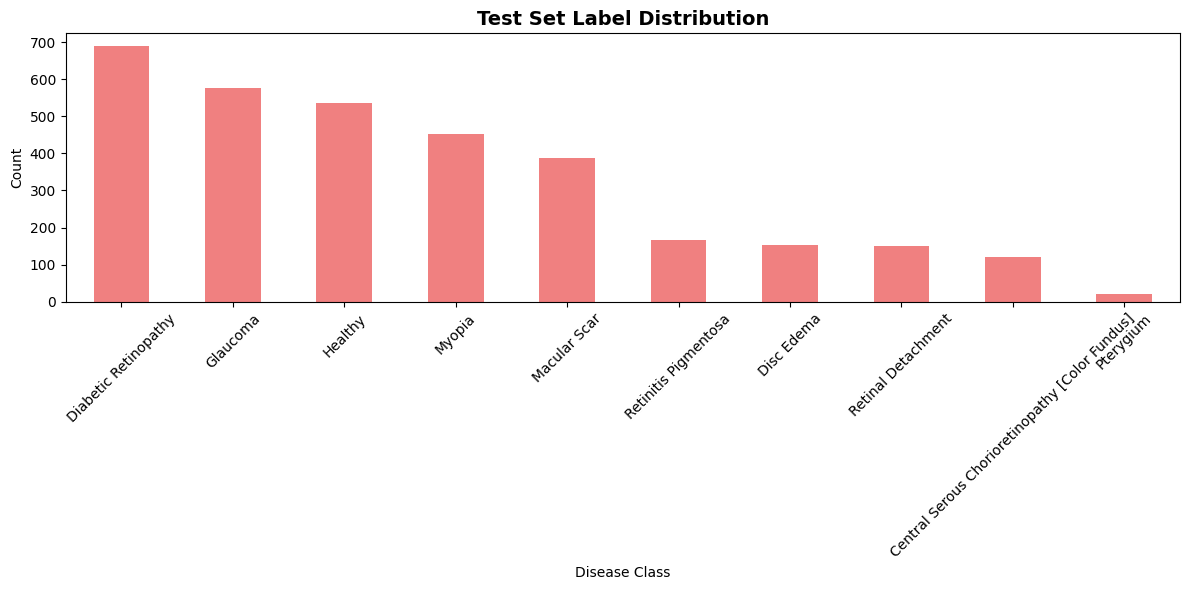

In [23]:
# Load and analyze test results
test_df = pd.read_csv(TEST_OUTPUT_PATH)

print(f"{'='*80}")
print(f"TEST SET STATISTICS")
print(f"{'='*80}")

print(f"\n📊 Dataset Statistics:")
print(f"  Total samples: {len(test_df)}")
print(f"  Unique prompts: {test_df['prompt'].nunique()}")
print(f"  Diversity: {test_df['prompt'].nunique()/len(test_df)*100:.1f}%")
print(f"  Disease classes: {test_df['label'].nunique()}")

print(f"\n📝 Prompt Statistics:")
print(f"  Avg length: {test_df['prompt'].str.len().mean():.1f} characters")
print(f"  Min length: {test_df['prompt'].str.len().min()} characters")
print(f"  Max length: {test_df['prompt'].str.len().max()} characters")

print(f"\n🏷️ Label Distribution:")
display(test_df['label'].value_counts())

print(f"\n📋 Sample Test Prompts:")
print(f"{'='*80}")
for i, row in test_df.head(5).iterrows():
    print(f"\n[{i+1}] {row['label']}")
    print(f"    {row['prompt'][:150]}...")

# Visualize test set distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
test_df['label'].value_counts().plot(kind='bar', ax=ax, color='lightcoral')
ax.set_title('Test Set Label Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Disease Class')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()